In [20]:
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import scipy.misc
import scipy.ndimage
from IPython.display import clear_output
import pandas as pd
import ast
import PIL
from PIL import Image
from torchvision import models
import time
import glob
with open('data/imagenet_classes.txt') as f:
    classes = [line.split(' ')[-1].strip() for line in f.readlines()]
from scipy.ndimage.filters import gaussian_filter
from skimage.transform import resize


In [76]:
 
def old_occ(input, model, c, k_size=1, vis=False, step_size=1, c_img=None):

    fig, axs = plt.subplots()
    input_min = torch.mean(input[0], dim =(-1,-2), keepdim=True)
    _, channels, yd, xd = input.shape
    unocc_pred = model(input)
    x_steps = range(0, xd - k_size + 1, step_size)
    y_steps = range(0, yd - k_size + 1, step_size)
    heatmap = np.zeros((len(y_steps), len(x_steps)))
    num_occs = 0
    hx = 0
    for x in x_steps:
        hy = 0
        for y in y_steps:
            occ_im = torch.Tensor(input.numpy().copy())
            occ_im[:,:,y: y + k_size, x: x + k_size] = torch.mean(occ_im[:,:,y: y + k_size, x: x + k_size][0], dim =(-1,-2), keepdim=True)
            diff = torch.relu(unocc_pred - model(occ_im))[0][c]
            heatmap[hy, hx] = diff
            num_occs += 1
            
            clear_output(wait=True)
            
            if vis:
                plt.show() 
                oi = np.transpose(original_input[:,:,:input_y_dim, :input_x_dim][0], (1, 2, 0))
                plt.imshow(oi.reshape(28,28), cmap='gray')              
                plt.imshow(clean_smap(heatmap, c_img.shape), alpha=0.5, cmap=plt.cm.jet)
                print(x + y, '/', len(y_steps)*len(x_steps))
            
            print(num_occs, diff)
            
            hy += 1
        hx += 1
    
    return clean_smap(heatmap, c_img.shape), num_occs


def rise(inp, model, c, num_occs, vis=False, c_img=None):
    fig, axs = plt.subplots()
    
    pred = model(inp)[0][c]
    N = num_occs
    s = 8
    p1 = 0.5
    inp_size = np.array(inp.shape[2:])
    cell_size = np.ceil(inp_size / s)
    up_size = (s + 1) * cell_size
    grid = np.random.rand(N, s, s) < p1
    grid = grid.astype('float32')
    
    masks = []
    preds = []
    sals = []
    
    for i in range(N):
        
        x = np.random.randint(0, cell_size[0])
        y = np.random.randint(0, cell_size[1])
        
        mask = resize(grid[i], up_size, order=1, mode='reflect', anti_aliasing=False)[x:x + inp_size[0], y:y + inp_size[1]]
        masks.append(mask)
    
        pred = model(torch.Tensor(masks[i]) * inp)[0][c].detach().numpy()
        preds.append(pred)
        
        clear_output(wait=True)
        
        if vis:
            plt.show() 
            oi = np.transpose(inp[0], (1, 2, 0))
            plt.imshow(oi.reshape(28,28), cmap='gray')
            sal = np.asarray(preds).reshape(i+1, -1).T.dot(np.asarray(masks).reshape(i+1, -1)).reshape(*inp_size)
            plt.imshow(clean_smap(sal, c_img.shape), alpha=0.5, cmap=plt.cm.jet)
            print(pred)

        print(i, '/', N)

    heatmap = np.asarray(preds).reshape(N, -1).T.dot(np.asarray(masks).reshape(N, -1)).reshape(*inp_size)
    heatmap = heatmap / N / p1
    
    return clean_smap(heatmap, c_img.shape), N


In [79]:

def mnist_bin_occ(original_input, model, c, vis=False, min_k=1, c_img=None):
    
    input_min = 0.0#torch.mean(original_input[0], dim =(-1,-2), keepdim=True)
    unoccluded_output = model(original_input).detach().numpy()#[0][c]
    
    _, channels, input_y_dim, input_x_dim = original_input.shape
    y_ix, x_ix = 0, 0
    y_dim = 2 ** int(np.ceil(np.log2(input_y_dim)))
    x_dim = 2 ** int(np.ceil(np.log2(input_x_dim)))
    input = np.zeros((_, channels, y_dim, x_dim))
    input[:,:,:input_y_dim, :input_x_dim] = original_input
    saliency_map = np.zeros((y_dim, x_dim))
    num_occs = 0
    depth = 0
    branches = [(x_dim, x_ix, y_dim, y_ix, depth, 0)]
    max_depth = (2 * max(np.log2(y_dim), np.log2(x_dim))) + 1
    
    fig, axs = plt.subplots()
    
    while len(branches) > 0:
        x_dim, x_ix, y_dim, y_ix, depth, threshold = branches.pop()
        
        if x_ix < input_x_dim and y_ix < input_y_dim:
            occluded_input = input.copy()
            m = np.mean(occluded_input[:,:,y_ix:y_ix + y_dim - max(0, y_ix + y_dim - input_y_dim), x_ix:x_ix + x_dim - max(0, x_ix + x_dim - input_x_dim)][0], axis=(-1,-2), keepdims=True)
            occluded_input[:,:,y_ix:y_ix + y_dim, x_ix:x_ix + x_dim] = input_min           
            occluded_output = model(torch.Tensor(occluded_input[:,:,:input_y_dim, :input_x_dim])).detach().numpy()#[0][c]
            output_difference = np.abs(np.sum(unoccluded_output - occluded_output))
            num_occs+=1
            clear_output(wait=True)
            
            
            if output_difference > threshold:
                depth += 1
                threshold = np.mean(saliency_map) / (max_depth - depth)

                saliency_map[y_ix:y_ix + y_dim, x_ix:x_ix + x_dim] += output_difference / ((y_dim - max(0, y_ix + y_dim - input_y_dim)) * (x_dim - max(0, x_ix + x_dim - input_x_dim)))
                              
                              
                if vis:
                    plt.show()
                    oi = np.transpose(original_input[:,:,:input_y_dim, :input_x_dim][0], (1, 2, 0))
                    plt.imshow(oi.reshape(28,28), cmap='gray')
                    smap = saliency_map[:input_y_dim, :input_y_dim]
                    plt.imshow(smap, alpha=0.5, cmap=plt.cm.jet)
                    print(x_dim, y_dim)
                     
                print(num_occs, threshold, output_difference)
                
                next_x_ix, next_y_ix = x_ix, y_ix
                if x_dim > y_dim:
                    x_dim = x_dim // 2
                    next_x_ix = x_ix + x_dim
                else:
                    y_dim = y_dim // 2
                    next_y_ix = y_ix + y_dim
                if (x_dim >= min_k) and (y_dim >= min_k):
                    branches.extend([(x_dim, x_ix, y_dim, y_ix, depth, threshold), (x_dim, next_x_ix, y_dim, next_y_ix, depth, threshold)])
    
    heatmap = clean_smap(saliency_map[:input_y_dim, :input_y_dim], c_img.shape, sigma=8)
    return heatmap, num_occs


def mean_bin_occ(original_input, model, c, vis=False, min_k=2, c_img=None):
    
    input_min = torch.mean(original_input[0], dim =(-1,-2), keepdim=True)
    unoccluded_output = model(original_input).detach().numpy()[0][c]
    
    _, channels, input_y_dim, input_x_dim = original_input.shape
    y_ix, x_ix = 0, 0
    y_dim = 2 ** int(np.ceil(np.log2(input_y_dim)))
    x_dim = 2 ** int(np.ceil(np.log2(input_x_dim)))
    input = np.zeros((_, channels, y_dim, x_dim))
    input[:,:,:input_y_dim, :input_x_dim] = original_input
    saliency_map = np.zeros((y_dim, x_dim))
    num_occs = 0
    depth = 0
    branches = [(x_dim, x_ix, y_dim, y_ix, depth, 0)]
    max_depth = (2 * max(np.log2(y_dim), np.log2(x_dim))) + 1
    
    fig, axs = plt.subplots()
    
    while len(branches) > 0:
        x_dim, x_ix, y_dim, y_ix, depth, threshold = branches.pop()
        
        if x_ix < input_x_dim and y_ix < input_y_dim:
            occluded_input = input.copy()
            m = np.mean(occluded_input[:,:,y_ix:y_ix + y_dim - max(0, y_ix + y_dim - input_y_dim), x_ix:x_ix + x_dim - max(0, x_ix + x_dim - input_x_dim)][0], axis=(-1,-2), keepdims=True)
            occluded_input[:,:,y_ix:y_ix + y_dim, x_ix:x_ix + x_dim] = m            
            occluded_output = model(torch.Tensor(occluded_input[:,:,:input_y_dim, :input_x_dim])).detach().numpy()[0][c]
            output_difference = np.max(unoccluded_output - occluded_output, 0)
            num_occs+=1
            clear_output(wait=True)
            
            
            if output_difference > threshold:
                depth += 1
                threshold = np.mean(saliency_map) / (max_depth - depth)

                saliency_map[y_ix:y_ix + y_dim, x_ix:x_ix + x_dim] += output_difference * depth
                              
                if vis:
                    plt.show()
                    oi = np.transpose(original_input[:,:,:input_y_dim, :input_x_dim][0], (1, 2, 0))
                    plt.imshow(oi.reshape(28,28), cmap='gray')
                    smap = saliency_map[:input_y_dim, :input_y_dim]
                    plt.imshow(smap, alpha=0.5, cmap=plt.cm.jet)
                    print(x_dim, y_dim)
                     
                print(num_occs, threshold, output_difference)
                
                next_x_ix, next_y_ix = x_ix, y_ix
                if x_dim > y_dim:
                    x_dim = x_dim // 2
                    next_x_ix = x_ix + x_dim
                else:
                    y_dim = y_dim // 2
                    next_y_ix = y_ix + y_dim
                if (x_dim >= min_k) and (y_dim >= min_k):
                    branches.extend([(x_dim, x_ix, y_dim, y_ix, depth, threshold), (x_dim, next_x_ix, y_dim, next_y_ix, depth, threshold)])
    
    heatmap = clean_smap(saliency_map[:input_y_dim, :input_y_dim], c_img.shape, sigma=8)
    return heatmap, num_occs

    
def clean_smap(smap, img_shape, interp=PIL.Image.LANCZOS, sigma=8):
    smap = Image.fromarray(smap-smap.min()).resize(img_shape[:-1], resample=interp)
    #smap = gaussian_filter(smap, sigma=sigma)
    return smap


In [5]:

train_net = False
batch_size = 4

transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

classes = [str(n) for n in range(10)]

PATH = './mnist_net.pth'

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=2)



class Net(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        self.gradients = None

    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        h = x.register_hook(self.activations_hook)
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return torch.nn.functional.softmax(x, dim=1)

    def get_activations_gradient(self):
        return self.gradients

    def get_activations(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        return x
 


def run_epochs(net, dataloader, criterion, optimizer, num_epochs, threshold):
    
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                avg_loss = running_loss / 2000
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, avg_loss))
                if avg_loss <= threshold:
                    return net
                running_loss = 0.0

    print('Finished Training')
    return net


net = Net()
num_epochs = 2
criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

threshold = 0.05
    
if train_net:
    
    net = run_epochs(net, trainloader, criterion, optimizer, num_epochs, threshold)

    torch.save(net.state_dict(), PATH)
else: 
    net = Net()
    net.load_state_dict(torch.load(PATH))
    
correct = 0
total = 0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

net.eval()

for data in testloader:
    test_images, test_labels = data
    outputs = net(test_images)
    _, predicted = torch.max(outputs.data, 1)
    total += test_labels.size(0)
    correct += (predicted == test_labels).sum().item()
    
    c = (predicted == test_labels).squeeze()
    label = test_labels.item()
    class_correct[label] += c.item()
    class_total[label] += 1

print('Accuracy of the network on test set: %d %%' % (
    100 * correct / total))

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of the network on test set: 98 %
Accuracy of     0 : 99 %
Accuracy of     1 : 99 %
Accuracy of     2 : 98 %
Accuracy of     3 : 98 %
Accuracy of     4 : 99 %
Accuracy of     5 : 99 %
Accuracy of     6 : 93 %
Accuracy of     7 : 97 %
Accuracy of     8 : 97 %
Accuracy of     9 : 97 %


Proposed Method, 15 Occlusions


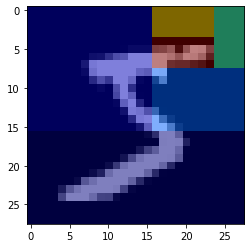

In [80]:
def save_hm(c_img, smap, title, im_name, predicted):
    fig, ax = plt.subplots()
    ax.imshow(c_img)
    ax.imshow(smap, cmap=plt.cm.jet, alpha=0.5)
    ax.set_title(title)
    ax.axis('off')
    plt.savefig('heatmaps/{}_pred_{}_{}'.format(im_name, predicted, title), bbox_inches='tight')
    plt.show()

net.eval()

num_examples = 1
save = True
note = 'mnist'
a = 1

cmap= plt.cm.jet

dataiter = iter(torch.utils.data.DataLoader(trainset, batch_size=1,shuffle=False, num_workers=2))
ks = [1,2,6]
num_cols = len(ks) + 5
good_preds = 0
n = 0
cols = []
smaps = []
while n < num_examples:
    n+=1
    ti, tl = dataiter.next()

    outputs = net(ti)[0]
    predicted = classes[torch.argmax(outputs).item()]
    actual = classes[tl]
    p_class = torch.argmax(outputs)
    confidence = max(outputs).item()

    c_img = ti[0]
    oi = np.transpose(c_img, (1, 2, 0)).reshape(28,28)
    v = True

    smap, occs = mnist_bin_occ(ti, net, p_class, vis=v, c_img=c_img)
    smaps.append(smap)
    c = 'Proposed Method, {} Occlusions'.format(int(occs))
    print(c)
    cols.append(c)
    """
    smap, occs = rise(ti, net, p_class, occs, c_img=c_img, vis=v)
    smaps.append(smap)
    c = 'RISE {}, Occlusions'.format(int(occs))
    print(c)
    cols.append(c)

    occs = 2000
    smap, occs = rise(ti, net, p_class, occs, c_img=c_img, vis=v)
    smaps.append(smap)
    c = 'RISE {}, Occlusions'.format(int(occs))
    print(c)
    cols.append(c)

    # Standard Occlusion
    ks = [32, 64]
    step = 8

    for k in ks:
        print('Standard Occlusion, kernel size {}...'.format(k))
        smap, occs = old_occ(ti, net, p_class, k, vis=v, step_size=step, c_img=c_img)
        smaps.append(smap)
        c = 'Sliding Window K{} S{}, {} Occlusions'.format(k, step, int(occs))
        print(c)
        cols.append(c)
    """
    
    

    

In [ ]:
"""
    thres = [0.01, 0.5]
    
    for t in thres:
        smap, occs = thresh_bin_occ(ti, net, p_class, vis=v, c_img=c_img, threshold=t)
        smaps.append(smap)
        c = 'Proposed Method Threshold {} {} Occlusions'.format(int(t*10), int(occs))
        print(c)
        cols.append(c)
        bin_occs.append(occs)
        save_hm(c_img, smap, c, im_name.split('/')[-1].split('.')[0], predicted)
    
    smap, occs = quick_bin_occ(ti, net, p_class, vis=v, c_img=c_img)
    smaps.append(smap)
    c = 'Proposed Method Quick Version {} Occlusions'.format(int(occs))
    print(c)
    cols.append(c)
    bin_occs.append(occs)
    
    save_hm(c_img, smap, c, im_name.split('/')[-1].split('.')[0], predicted)
    
    smap, occs = pix_bin_occ(ti, net, p_class, vis=v, c_img=c_img)
    smaps.append(smap)
    c = 'Proposed Method Pix Version {} Occlusions'.format(int(occs))
    print(c)
    cols.append(c)
    bin_occs.append(occs)
    
    save_hm(c_img, smap, c, im_name.split('/')[-1].split('.')[0], predicted)
    
    smap, occs = bin_occ(ti, net, p_class, vis=v, c_img=c_img)
    smaps.append(smap)
    c = 'Proposed Method Auto Threshold {} Occlusions'.format(int(occs))
    print(c)
    cols.append(c)
    bin_occs.append(occs)
    
    save_hm(c_img, smap, c, im_name.split('/')[-1].split('.')[0], predicted)

    smap, occs = conf_bin_occ(ti, net, p_class, vis=v, c_img=c_img, threshold=confidence)
    smaps.append(smap)
    c = 'Proposed Method Confidence-Based Threshold {} {} Occlusions'.format(int(confidence*100), int(occs))
    print(c)
    cols.append(c)
    bin_occs.append(occs)  
    
    save_hm(c_img, smap, c, im_name.split('/')[-1].split('.')[0], predicted)
    
    r_occs = max(bin_occs)
    smap, occs = rise(ti, net, p_class, r_occs, c_img=c_img, vis=v)
    smaps.append(smap)
    c = 'RISE {} Occlusions'.format(int(r_occs))
    print(c)
    cols.append(c)
    
    save_hm(c_img, smap, c, im_name.split('/')[-1].split('.')[0], predicted)

    # Standard Occlusion
    ks = [64]
    step = 8
    
    for k in ks:
        print('Standard Occlusion, kernel size {}...'.format(k))
        smap, occs = old_occ(ti, net, p_class, k, vis=v, step_size=step, c_img=c_img)
        smaps.append(smap)
        c = 'Sliding Window K{} S{} {} Occlusions'.format(k, step, int(occs))
        print(c)
        cols.append(c)
        save_hm(c_img, smap, c, im_name.split('/')[-1].split('.')[0], predicted)
    
    num_cols = len(cols)
    
    fig, axs = plt.subplots(1, num_cols, figsize=(10*num_cols, 10*num_cols))

    for i in range(num_cols):
        axs[i].imshow(c_img)
        axs[i].imshow(smaps[i], cmap=plt.cm.jet, alpha=0.5)
        axs[i].set_title(cols[i])
        axs[i].axis('off')

    plt.savefig('heatmaps/{}_{}'.format(im_name.split('/')[-1].split('.')[0], predicted), bbox_inches='tight')

    plt.show()
    img.close()

    """